# Ligand / DNA complex MD simulation

## ``Gromacs_py`` basic example

Here is an example of a short simulation of a G-quadruplex bound to a small molecule.
Five successive steps are used:

1. Topologie creation using ``GmxSys.prepare_top()``.
2. Minimisation of the structure using ``GmxSys.em_2_steps()``.
3. Solvation of the system using ``GmxSys.solvate_add_ions()``.
4. Equilibration of the system using ``GmxSys.em_equi_three_step_iter_error()``.
5. Production run using ``GmxSys.production()``.

## Import

In [1]:
import os
import urllib.request
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from gromacs_py import gmx

In [2]:
cd /home/murail/Documents/Code/gromacs_py/docs/notebook

/home/murail/Documents/Code/gromacs_py/docs/notebook


In [3]:
rm -r data_lig_dna/

## Simulation setup

- Define a few variables for you simulation, like:
    - simulation output folders
    - ionic concentration
    - number of minimisation steps
    - equilibration and production time

In [3]:
PDB_ID = '5W77'

# Setup data location
DATA_OUT = 'data_lig_dna'

# System Setup
vsite='none'
ion_C = 0.15
sys_top_folder = os.path.join(DATA_OUT, 'sys_top')

# Energy Minimisation
em_folder = os.path.join(DATA_OUT, 'em')
em_sys_folder = os.path.join(DATA_OUT, 'sys_em')
em_step_number = 10000

# Equillibration
equi_folder = os.path.join(DATA_OUT, 'sys_equi')
HA_time = 0.5
CA_time = 1.0
CA_LOW_time = 2.0

dt_HA = 0.001
dt = 0.002

HA_step = 1000 * HA_time / dt_HA
CA_step = 1000 * CA_time / dt
CA_LOW_step = 1000 * CA_LOW_time / dt

# Production
prod_folder = os.path.join(DATA_OUT, 'sys_prod')
prod_time = 10.0

prod_step = 1000 * prod_time / dt

## Get PDB file from the ``rcsb.org`` website 

In [4]:
os.makedirs(DATA_OUT, exist_ok = True)

raw_pdb = urllib.request.urlretrieve('http://files.rcsb.org/download/{}.pdb'.format(PDB_ID),
                           '{}/{}.pdb'.format(DATA_OUT, PDB_ID))

## Structure preparation

- the PDB ID `5W77` is a NMR structure containing several models. Here we extract only the first model and save the coordinates.

In [5]:
from pdb_manip_py import pdb_manip

In [6]:
# Extract first conf:

pdb_multi = pdb_manip.Multi_Coor(raw_pdb[0])
pdb_model_1 = '{}/{}_model_1.pdb'.format(DATA_OUT, PDB_ID)
pdb_multi.coor_list[0].write_pdb(pdb_model_1)

### Create the `GmxSys` object

- Here we will include a ligand in the simulation
- When using the `prepare_top()` function, the `include_mol` argument must be defined.
- `include_mol` is a dict with the residue name as key, and the molecule SMILE as value eg:
    - `include_mol={'9WP': 'Cc1c(c2c(o1)ccc(c2CN3CCCCCC3)O)C(=O)Nc4ccc(cc4)C(F)(F)F'}`

In [7]:
md_sys = gmx.GmxSys(name=PDB_ID, coor_file=pdb_model_1)
md_sys.prepare_top(out_folder=os.path.join(DATA_OUT, 'dna_lig_top'),
                   ff='amber99sb-ildn',
                   include_mol={'9WP': 'Cc1c(c2c(o1)ccc(c2CN3CCCCCC3)O)C(=O)Nc4ccc(cc4)C(F)(F)F'})

residue(s) K not included, add this residue in ...


acpype -i 9WP_h_unique.pdb -b 9WP -c bcc -a gaff -o gmx


## Energy minimisation

In [8]:
md_sys.em_2_steps(out_folder=os.path.join(DATA_OUT, 'prot_em'),
                  no_constr_nsteps=10000,
                  constr_nsteps=10000,
                  posres="",
                  emtol=0.1, nstxout=100, maxwarn=3,
                  create_box_flag=True)

### 3D vizualisation using `nglview`

Not much append in the second minimisation, we can have a look at the first one using md_sys.sys_history[-1], which is considered as a `GmxSys` object.

Use the `coor_traj` atribute of the `GmxSys` object to vizualise the trajectory.
Note that that the `simpletraj` library is a dependenie. 
To install `simpletraj` use:

```
pip install simpletraj
```

- first you should make molecule whole using `convert_trj()` function.

In [11]:
md_sys.sys_history[-1].center_mol_box(traj=True)
md_sys.sys_history[-1].center_mol_box(traj=False)

gmx make_ndx -f data_lig_dna/prot_em/Init_em_5W77.gro -o data_lig_dna/prot_em/Init_em_5W77.ndx
gmx trjconv -f data_lig_dna/prot_em/Init_em_5W77_compact.xtc -o data_lig_dna/prot_em/Init_em_5W77_compact_compact.xtc -s data_lig_dna/prot_em/Init_em_5W77.tpr -ur tric -pbc mol -center yes -n data_lig_dna/prot_em/Init_em_5W77.ndx
gmx make_ndx -f data_lig_dna/prot_em/Init_em_5W77.gro -o data_lig_dna/prot_em/Init_em_5W77.ndx
gmx trjconv -f data_lig_dna/prot_em/Init_em_5W77.gro -o data_lig_dna/prot_em/Init_em_5W77_compact.pdb -s data_lig_dna/prot_em/Init_em_5W77.tpr -ur tric -pbc mol -center yes -n data_lig_dna/prot_em/Init_em_5W77.ndx


In [12]:
view = md_sys.sys_history[-1].view_traj()
view.add_representation(repr_type='licorice', selection='nucleic')
view

NGLWidget(max_frame=79)

In [ ]:
# To hide this cell add the following info in the cell metadata:
# "nbsphinx": "hidden"
import nglview as nv
nv.write_html('../_static/dna_em.html', [view], frame_range=(0, 100))
from IPython.display import IFrame

In [ ]:
# Unecessary, only need to nglview online:
IFrame(src='../_static/dna_em.html', width=800, height=300)

## Solvation (water and $Na^{+} Cl^{-}$)

In [13]:
md_sys.solvate_add_ions(out_folder=os.path.join(DATA_OUT, 'sys_top'),
                        ion_C=0.15, maxwarn=3, create_box_flag=False)
md_sys.display()


name         : 5W77
sim_name     : 5W77
coor_file    : data_lig_dna/sys_top/5W77_water_ion.gro
top_file     : data_lig_dna/sys_top/5W77_water_ion.top
tpr          : data_lig_dna/prot_em/5W77.tpr
mdp          : data_lig_dna/prot_em/5W77.mdp
xtc          : data_lig_dna/prot_em/5W77.trr
edr          : data_lig_dna/prot_em/5W77.edr
log          : data_lig_dna/prot_em/5W77.log
nt           : 0
ntmpi        : 0
sys_history  : 2


## System minimisation

In [14]:
md_sys.em_2_steps(out_folder=os.path.join(DATA_OUT, 'sys_em'),
                  no_constr_nsteps=10000,
                  constr_nsteps=10000,
                  posres="",maxwarn=3)

In [15]:
md_sys.center_mol_box(traj=False)

gmx make_ndx -f data_lig_dna/sys_em/5W77.gro -o data_lig_dna/sys_em/5W77.ndx


## System equilibration

In [17]:
HA_time = 0.25
CA_time = 0.5
CA_LOW_time = 1.0
dt = 0.002
dt_HA = 0.001

md_sys.equi_three_step(out_folder=os.path.join(DATA_OUT, 'sys_equi'),
                       nsteps_HA=1000 * HA_time / dt_HA,
                       nsteps_CA=1000 * CA_time / dt,
                       nsteps_CA_LOW=1000 * CA_LOW_time / dt,
                       dt=dt, dt_HA=dt_HA, maxwarn=3,
                       tc_grps='DNA 9WP Water_and_ions',
                       tau_t= '0.1 0.1 0.1',
                       ref_t= '310 310 310')


### Plot RMSD

In [19]:
# Define reference structure for RMSD calculation
ref_sys =  md_sys.sys_history[1]

md_sys.sys_history[-2].center_mol_box(traj=True)
rmsd_pd_1 = md_sys.sys_history[-2].get_rmsd(['DNA', 'DNA'], ref_sys=ref_sys)
md_sys.sys_history[-1].center_mol_box(traj=True)
rmsd_pd_2 = md_sys.sys_history[-1].get_rmsd(['DNA', 'DNA'], ref_sys=ref_sys)
md_sys.center_mol_box(traj=True)
rmsd_pd_3 = md_sys.get_rmsd(['DNA', 'DNA'], ref_sys=ref_sys)


rmsd_pd_1['label'] = 'HA_constr'
rmsd_pd_2['label'] = 'CA_constr'
rmsd_pd_2['time'] = rmsd_pd_2['time'] + rmsd_pd_1['time'].max()
rmsd_pd_3['label'] = 'CA_LOW_constr'
rmsd_pd_3['time'] = rmsd_pd_3['time'] + rmsd_pd_2['time'].max()

rmsd_pd = pd.concat([rmsd_pd_1, rmsd_pd_2, rmsd_pd_3])

gmx make_ndx -f data_lig_dna/sys_equi/00_equi_HA/equi_HA_5W77.gro -o data_lig_dna/sys_equi/00_equi_HA/equi_HA_5W77.ndx
gmx rms -s data_lig_dna/prot_em/Init_em_5W77.tpr -f data_lig_dna/sys_equi/00_equi_HA/equi_HA_5W77_compact.xtc -n data_lig_dna/sys_equi/00_equi_HA/equi_HA_5W77.ndx -o tmp_rmsd.xvg -fit rot+trans -ng 1 -pbc no
gmx make_ndx -f data_lig_dna/sys_equi/01_equi_CA/equi_CA_5W77.gro -o data_lig_dna/sys_equi/01_equi_CA/equi_CA_5W77.ndx
gmx trjconv -f data_lig_dna/sys_equi/01_equi_CA/equi_CA_5W77.xtc -o data_lig_dna/sys_equi/01_equi_CA/equi_CA_5W77_compact.xtc -s data_lig_dna/sys_equi/01_equi_CA/equi_CA_5W77.tpr -ur tric -pbc mol -center yes -n data_lig_dna/sys_equi/01_equi_CA/equi_CA_5W77.ndx
gmx rms -s data_lig_dna/prot_em/Init_em_5W77.tpr -f data_lig_dna/sys_equi/01_equi_CA/equi_CA_5W77_compact.xtc -n data_lig_dna/sys_equi/01_equi_CA/equi_CA_5W77.ndx -o tmp_rmsd.xvg -fit rot+trans -ng 1 -pbc no
gmx make_ndx -f data_lig_dna/sys_equi/02_equi_CA_LOW/equi_CA_LOW_5W77.gro -o data_li

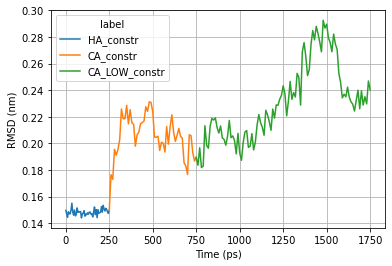

In [20]:
ax = sns.lineplot(x="time", y="DNA",
                  hue="label",
                  data=rmsd_pd)

ax.set_ylabel('RMSD (nm)')
ax.set_xlabel('Time (ps)')
plt.grid()

## Production

In [21]:
prod_time = 10.0
prod_folder = os.path.join(DATA_OUT, 'sys_prod') 


md_sys.production(out_folder=prod_folder,
                  nsteps=1000 * prod_time / dt,
                  dt=dt, maxwarn=1,
                  tc_grps='DNA 9WP Water_and_ions',
                  tau_t= '0.1 0.1 0.1',
                  ref_t= '310 310 310')


gmx mdrun -s prod_5W77.tpr -deffnm prod_5W77 -nt 0 -ntmpi 0 -nsteps -2 -nocopyright -append -cpi prod_5W77.cpt


  0%|          | 0/5000000 [00:00<?, ?it/s]

In [23]:
# Center trajectory
md_sys.center_mol_box(traj=True)
rmsd_prod_pd = md_sys.get_rmsd(['DNA', 'DNA'], ref_sys=ref_sys)
rmsd_prod_pd['label'] = 'Production'

rmsd_prod_pd['time'] = rmsd_prod_pd['time'] + rmsd_pd['time'].max()
rmsd_all_pd = pd.concat([rmsd_pd, rmsd_prod_pd])

gmx make_ndx -f data_lig_dna/sys_prod/prod_5W77.gro -o data_lig_dna/sys_prod/prod_5W77.ndx
gmx trjconv -f data_lig_dna/sys_prod/prod_5W77.xtc -o data_lig_dna/sys_prod/prod_5W77_compact.xtc -s data_lig_dna/sys_prod/prod_5W77.tpr -ur tric -pbc mol -center yes -n data_lig_dna/sys_prod/prod_5W77.ndx
gmx rms -s data_lig_dna/prot_em/Init_em_5W77.tpr -f data_lig_dna/sys_prod/prod_5W77_compact.xtc -n data_lig_dna/sys_prod/prod_5W77.ndx -o tmp_rmsd.xvg -fit rot+trans -ng 1 -pbc no


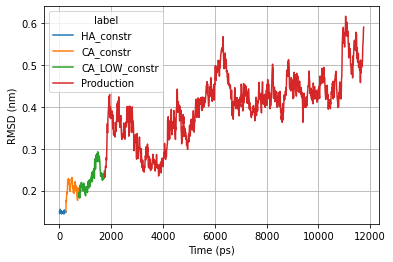

In [24]:
ax = sns.lineplot(x="time", y="DNA",
                  hue="label",
                  data=rmsd_all_pd)
ax.set_ylabel('RMSD (nm)')
ax.set_xlabel('Time (ps)')
plt.grid()

## Prepare trajectory

In [25]:
# Center coor
md_sys.center_mol_box(traj=False)

gmx make_ndx -f data_lig_dna/sys_prod/prod_5W77.gro -o data_lig_dna/sys_prod/prod_5W77.ndx
gmx trjconv -f data_lig_dna/sys_prod/prod_5W77.gro -o data_lig_dna/sys_prod/prod_5W77_compact.pdb -s data_lig_dna/sys_prod/prod_5W77.tpr -ur tric -pbc mol -center yes -n data_lig_dna/sys_prod/prod_5W77.ndx


In [28]:
md_sys.convert_trj(select='DNA\nSystem\n', fit='rot+trans', pbc='none', skip='10')

gmx trjconv -f data_lig_dna/sys_prod/prod_5W77_compact_compact.xtc -o data_lig_dna/sys_prod/prod_5W77_compact_compact_compact.xtc -s data_lig_dna/sys_prod/prod_5W77.tpr -ur compact -pbc none -fit rot+trans -n data_lig_dna/sys_prod/prod_5W77.ndx -skip 10


In [30]:
view = md_sys.view_traj()
view.add_representation(repr_type='licorice', selection='nucleic')
view.center(selection='nucleic')
view.add_unitcell()
view

NGLWidget(max_frame=100)

In [31]:
# To hide this cell add the following info in the cell metadata:
# "nbsphinx": "hidden"
import nglview as nv
nv.write_html('../_static/dna_prod_traj.html', [view], frame_range=(0, 100))
from IPython.display import IFrame

In [32]:
# Unecessary, only need to nglview online:
IFrame(src='../_static/dna_prod_traj.html', width=800, height=300)